In [1]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
import pickle
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from volsense_pkg.data_fetching.multi_fetch import fetch_multi_ohlcv, build_multi_dataset
from volsense_pkg.data_fetching.fetch_yf import fetch_ohlcv
from volsense_pkg.models.global_vol_forecaster import (
    build_global_splits,
    GlobalVolForecaster,
    TrainConfig,
    train_global_model
)
from torch.utils.data import DataLoader

In [2]:
# ===============================
# 🌍 Multi-Horizon Training (1,5,10)
# Uses the same infra: build_global_splits + train_global_model
# ===============================

# --- 0) Assumptions / Inputs --------------------------------
# multi_df already exists with at least: ['date','ticker','return','realized_vol']
# If you’re loading from disk, uncomment:

multi_df = pd.read_csv("../data/processed/global_volatility_dataset.csv")

multi_df = multi_df.copy()
EPS = 1e-6

# Ensure dtype + sort
if not np.issubdtype(multi_df["date"].dtype, np.datetime64):
    multi_df["date"] = pd.to_datetime(multi_df["date"], errors="coerce")
multi_df.dropna(subset=["date"], inplace=True)
multi_df.sort_values(["ticker","date"], inplace=True)

# --- 1) Targets + Features (same style as your single-horizon best run) ---
# Log-vol target (base)
multi_df["realized_vol_log"] = np.log(multi_df["realized_vol"] + EPS)

# Rolling/ratio/chg/vol-of-vol features (per-ticker)
g = multi_df.groupby("ticker", group_keys=False)
multi_df["vol_3d"]   = g["realized_vol"].apply(lambda s: s.rolling(3, min_periods=1).mean())
multi_df["vol_10d"]  = g["realized_vol"].apply(lambda s: s.rolling(10, min_periods=1).mean())
multi_df["vol_ratio"]= multi_df["vol_3d"] / (multi_df["vol_10d"] + EPS)
multi_df["vol_chg"]  = multi_df["vol_3d"] - multi_df["vol_10d"]
multi_df["vol_vol"]  = g["realized_vol"].apply(lambda s: s.rolling(10, min_periods=2).std())

# Market-level cross-section dispersion each day, then per-ticker 1D lag
multi_df["market_stress"] = multi_df.groupby("date")["return"].transform(lambda x: x.std())
multi_df["market_stress_1d_lag"] = g["market_stress"].shift(1)

# Simple 5D rolling skew of returns
def _rolling_skew(x):
    if len(x) < 3:
        return np.nan
    m, sd = np.mean(x), np.std(x)
    sd = sd if sd > 0 else EPS
    return np.mean(((x - m) / sd) ** 3)

multi_df["skew_5d"] = g["return"].apply(lambda s: s.rolling(5, min_periods=3).apply(_rolling_skew, raw=True))

# Calendar features (they were cheap; keep them)
multi_df["day_of_week"] = multi_df["date"].dt.dayofweek / 6.0
multi_df["month_sin"]   = np.sin(2 * np.pi * multi_df["date"].dt.month / 12)
multi_df["month_cos"]   = np.cos(2 * np.pi * multi_df["date"].dt.month / 12)

# Forward/Backward fill per ticker to avoid gaps introduced by rolling
multi_df = multi_df.groupby("ticker", group_keys=False).apply(lambda g: g.ffill().bfill())

C:\Users\rahul\AppData\Local\Temp\ipykernel_42100\2273424451.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  multi_df = multi_df.groupby("ticker", group_keys=False).apply(lambda g: g.ffill().bfill())


In [3]:
# --- 🔍 Dataset sanity diagnostics ---
print("\n🔎 Checking dataset for NaN/Inf before training...")

cols_to_check = ["realized_vol", "realized_vol_log"] + [
    "vol_3d","vol_10d","vol_ratio","vol_chg","vol_vol",
    "market_stress","market_stress_1d_lag","skew_5d",
    "day_of_week","month_sin","month_cos"
]

summary = []
for c in cols_to_check:
    n_nan = multi_df[c].isna().sum()
    n_inf = np.isinf(multi_df[c].values).sum()
    summary.append((c, n_nan, n_inf))

print("Column | #NaN | #Inf")
for c, n_nan, n_inf in summary:
    print(f"{c:<25} {n_nan:>6} {n_inf:>6}")

# Drop any rows that still contain NaN/Inf in key columns
multi_df = multi_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["realized_vol_log"])
print("\n✅ Dataset ready. Remaining rows:", len(multi_df))



🔎 Checking dataset for NaN/Inf before training...
Column | #NaN | #Inf
realized_vol                   0      0
realized_vol_log               0      0
vol_3d                         0      0
vol_10d                        0      0
vol_ratio                      0      0
vol_chg                        0      0
vol_vol                        0      0
market_stress                  0      0
market_stress_1d_lag           0      0
skew_5d                        0      0
day_of_week                    0      0
month_sin                      0      0
month_cos                      0      0

✅ Dataset ready. Remaining rows: 400341


In [ ]:
multi_df["target_smooth"] = (
    multi_df.groupby("ticker")["realized_vol_log"]
    .transform(lambda x: x.ewm(span=3, adjust=False).mean())
)

# --- 2) Choose horizons and config --------------------------
HORIZONS = [1, 5, 10]  # <- multi-horizon targets
EXTRA_FEATURES = [
    "vol_3d","vol_10d","vol_ratio","vol_chg","vol_vol",
    "market_stress","market_stress_1d_lag","skew_5d",
    "day_of_week","month_sin","month_cos"
]

cfg = TrainConfig(
    window=40,
    horizons=[1, 5, 10],
    stride=1,
    val_start="2025-01-01",
    target_col="realized_vol_log",
    extra_features=EXTRA_FEATURES,
    epochs=30,             # let regularized model run a bit longer
    lr=2e-4,               # slightly lower LR for smoother updates
    batch_size=256,
    oversample_high_vol=False,
    cosine_schedule=True,
    device="cpu"
)


cfg.target_col = "target_smooth"



# --- 🔬 Quick sanity forward test before full training ---

print("\n🔎 Running one-batch forward test...")

# Temporarily build a small dataset for smoke test
train_ds, val_ds, ticker_to_id, scalers = build_global_splits(multi_df, cfg)
loader = DataLoader(train_ds, batch_size=8, shuffle=True)

t_id, X, y = next(iter(loader))
print("Shapes:", X.shape, y.shape)
print("Sample target values:", y[0])

# Initialize model
model = GlobalVolForecaster(
    n_tickers=len(ticker_to_id),
    window=cfg.window,
    n_horizons=cfg.horizons,
    emb_dim=16,
    hidden_dim=160,
    num_layers=3,
    dropout=0.2,
    attention=True,
    residual_head=True,
    input_size=len(["return"] + (cfg.extra_features or []))
)

with torch.no_grad():
    yhat = model(t_id, X)
    print("Forward output finite?", torch.isfinite(yhat).all().item())

if torch.isnan(yhat).any():
    raise ValueError("❌ Model produced NaN outputs before training.")
else:
    print("✅ Forward pass OK — continuing to training.")


# --- 3) Train (single call; no manual loops here) -----------
model, hist, val_loader, ticker_to_id, scalers, features = train_global_model(multi_df, cfg)

print(f"\n✅ Multi-horizon training complete for {len(ticker_to_id)} tickers.")
print(f"🧩 Horizons: {HORIZONS}")
print(f"🛠️  Features used ({len(features)}): {features}")
print(f"📉 Final Train Loss: {hist['train'][-1]:.4f} | Val Loss: {hist['val'][-1]:.4f}")


🔎 Running one-batch forward test...
Shapes: torch.Size([8, 40, 12]) torch.Size([8, 3])
Sample target values: tensor([-1.7968, -1.6943, -1.6154])
Forward output finite? True
✅ Forward pass OK — continuing to training.

🚀 Training GlobalVolForecaster on 104 tickers...

Epoch 1/30 | Train Loss: 0.0791 | Val Loss: 0.0608
Epoch 2/30 | Train Loss: 0.0467 | Val Loss: 0.0544
Epoch 3/30 | Train Loss: 0.0419 | Val Loss: 0.0515
Epoch 4/30 | Train Loss: 0.0394 | Val Loss: 0.0484
Epoch 5/30 | Train Loss: 0.0378 | Val Loss: 0.0494
Epoch 6/30 | Train Loss: 0.0367 | Val Loss: 0.0484
Epoch 7/30 | Train Loss: 0.0360 | Val Loss: 0.0497
Epoch 8/30 | Train Loss: 0.0357 | Val Loss: 0.0468
Epoch 9/30 | Train Loss: 0.0352 | Val Loss: 0.0489
Epoch 10/30 | Train Loss: 0.0349 | Val Loss: 0.0469
Epoch 11/30 | Train Loss: 0.0347 | Val Loss: 0.0458
Epoch 12/30 | Train Loss: 0.0345 | Val Loss: 0.0477
Epoch 13/30 | Train Loss: 0.0342 | Val Loss: 0.0470
Epoch 14/30 | Train Loss: 0.0341 | Val Loss: 0.0478
Epoch 15/30 

In [4]:
# --- 4) Save checkpoint + metadata + pickle --------------------------
import pickle

os.makedirs("checkpoints", exist_ok=True)

base = "checkpoints/global_vol_forecaster_multi_v1"
ckpt_path = f"{base}.pth"
meta_path = f"{base}.meta.json"
full_pkl_path = f"{base}_full.pkl"
bundle_pkl_path = f"{base}_bundle.pkl"

# 1) Weights checkpoint
torch.save(model.state_dict(), ckpt_path)

# 2) Metadata JSON
config_dict = {
    "window": cfg.window,
    "stride": cfg.stride,
    "val_start": cfg.val_start,
    "batch_size": cfg.batch_size,
    "lr": cfg.lr,
    "epochs": cfg.epochs,
    "device": cfg.device,
    "cosine_schedule": cfg.cosine_schedule,
    "oversample_high_vol": cfg.oversample_high_vol,
    "target_col": cfg.target_col,
}
with open(meta_path, "w") as f:
    json.dump({
        "ticker_to_id": ticker_to_id,
        "features": features,
        "horizons": HORIZONS,
        "config": config_dict,
    }, f, indent=2)

# 3) Full model pickle (architecture + weights; requires same module path on load)
with open(full_pkl_path, "wb") as f:
    pickle.dump(model, f)

# 4) Portable bundle pickle (state_dict + metadata; more robust to refactors)
bundle = {
    "arch": model.__class__.__name__,
    "module_path": model.__class__.__module__,
    "state_dict": {k: v.cpu() for k, v in model.state_dict().items()},
    "ticker_to_id": ticker_to_id,
    "features": features,
    "horizons": HORIZONS,
    "scalers": scalers,
    "config": config_dict,
}
with open(bundle_pkl_path, "wb") as f:
    pickle.dump(bundle, f)

print(f"💾 Saved checkpoint -> {ckpt_path}")
print(f"💾 Saved metadata   -> {meta_path}")
print(f"💾 Saved full pkl   -> {full_pkl_path}")
print(f"💾 Saved bundle pkl -> {bundle_pkl_path}")

💾 Saved checkpoint -> checkpoints/global_vol_forecaster_multi_v1.pth
💾 Saved metadata   -> checkpoints/global_vol_forecaster_multi_v1.meta.json
💾 Saved full pkl   -> checkpoints/global_vol_forecaster_multi_v1_full.pkl
💾 Saved bundle pkl -> checkpoints/global_vol_forecaster_multi_v1_bundle.pkl


,horizon,rmse,mae
0,1,0.031059,0.017153
1,5,0.074653,0.037818
2,10,0.127484,0.069255


,ticker,horizon,rmse,mae
0,AAPL,1,0.029310,0.017945
1,AAPL,5,0.080986,0.048394
2,AAPL,10,0.154622,0.096797
3,ABBV,1,0.017723,0.012187
4,ABBV,5,0.040191,0.027258


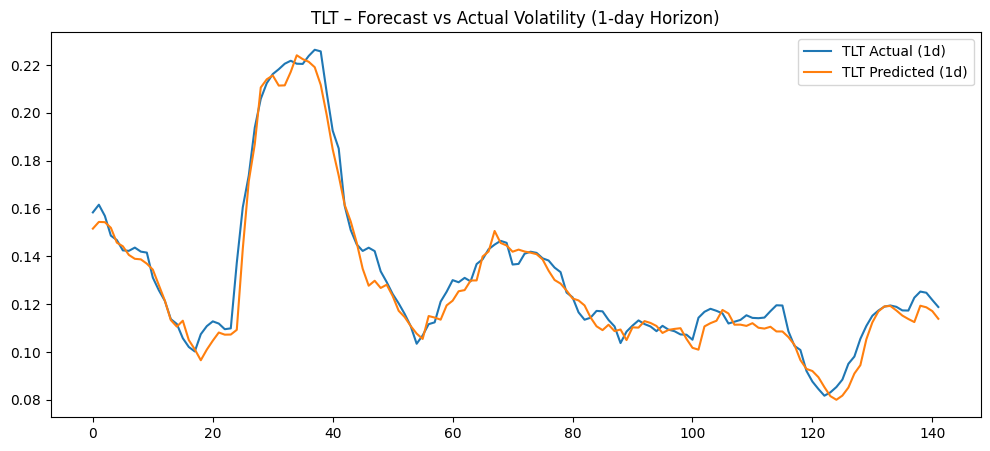

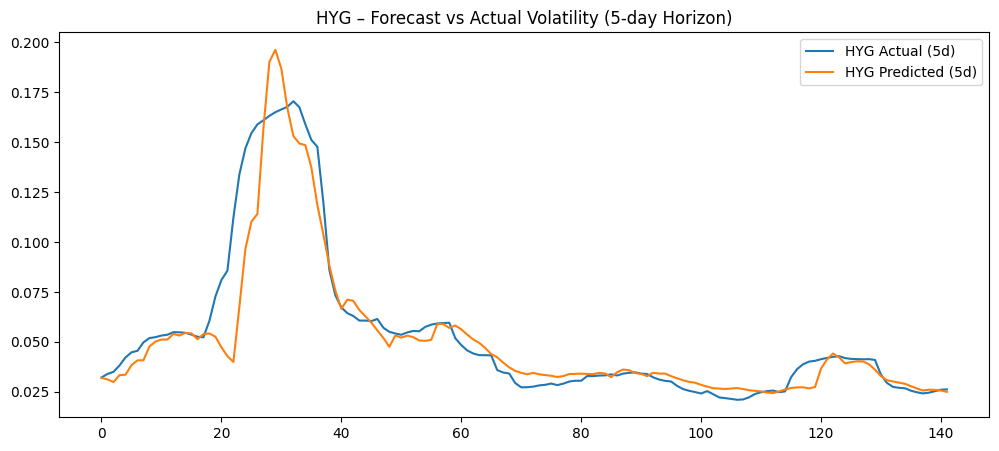

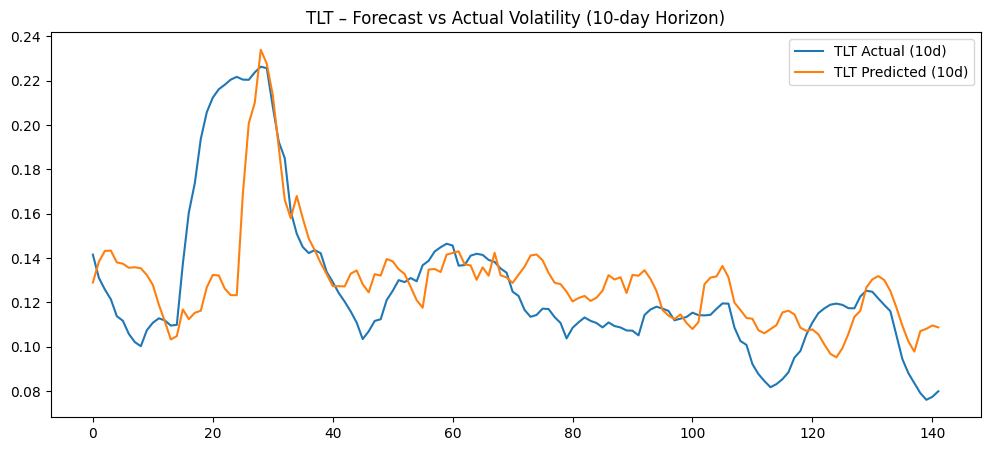

💾 Saved metrics -> global_lstm_multi_metrics.csv


In [7]:
# ============================================================
# 📈 Evaluate Multi-Horizon GlobalVolForecaster (1d, 5d, 10d)
# ============================================================


DEVICE = cfg.device
MODEL = model.to(DEVICE)
MODEL.eval()

# --- Run inference ---
all_preds, all_trues, all_tids = [], [], []

with torch.no_grad():
    for tid, X, y in val_loader:
        tid, X, y = tid.to(DEVICE), X.to(DEVICE), y.to(DEVICE)
        preds = MODEL(tid, X)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(y.cpu().numpy())
        all_tids.append(tid.cpu().numpy())

preds_scaled = np.concatenate(all_preds)
trues_scaled = np.concatenate(all_trues)
tids = np.concatenate(all_tids)

# --- Directly exp-transform since target was log(vol) ---
preds_vol = np.exp(preds_scaled)
trues_vol = np.exp(trues_scaled)

# --- Aggregate metrics per horizon ---
horizons = cfg.horizons if isinstance(cfg.horizons, (list, tuple)) else [cfg.horizons]
rows = []
for h_idx, h in enumerate(horizons):
    rmse = np.sqrt(mean_squared_error(trues_vol[:, h_idx], preds_vol[:, h_idx]))
    mae = mean_absolute_error(trues_vol[:, h_idx], preds_vol[:, h_idx])
    rows.append({"horizon": h, "rmse": rmse, "mae": mae})
metrics_overall = pd.DataFrame(rows)
display(metrics_overall.style.set_caption("📊 Multi-Horizon RMSE & MAE"))

# --- Per-ticker metrics ---
rows = []
id_to_ticker = {v: k for k, v in ticker_to_id.items()}
for tid in np.unique(tids):
    tkr = id_to_ticker[int(tid)]
    mask = (tids == tid)
    for h_idx, h in enumerate(horizons):
        rows.append({
            "ticker": tkr,
            "horizon": h,
            "rmse": np.sqrt(mean_squared_error(trues_vol[mask, h_idx], preds_vol[mask, h_idx])),
            "mae": mean_absolute_error(trues_vol[mask, h_idx], preds_vol[mask, h_idx])
        })
metrics_df = pd.DataFrame(rows)
display(metrics_df.head())

# --- Representative plots for best tickers in each horizon ---
for target_h in [1, 5, 10]:
    if target_h not in horizons:
        continue
    best_tkr = (
        metrics_df.query(f"horizon == {target_h}")
        .sort_values("rmse")
        .iloc[0]["ticker"]
    )
    tid_best = list(id_to_ticker.keys())[list(id_to_ticker.values()).index(best_tkr)]
    mask = (tids == tid_best)
    h_idx = horizons.index(target_h)
    
    plt.figure(figsize=(12,5))
    plt.plot(trues_vol[mask][:200, h_idx], label=f"{best_tkr} Actual ({target_h}d)")
    plt.plot(preds_vol[mask][:200, h_idx], label=f"{best_tkr} Predicted ({target_h}d)")
    plt.title(f"{best_tkr} – Forecast vs Actual Volatility ({target_h}-day Horizon)")
    plt.legend()
    plt.show()

# --- Save metrics ---
metrics_df.to_csv("../data/metrics/global_lstm_multi_metrics.csv", index=False)
print("💾 Saved metrics -> global_lstm_multi_metrics.csv")

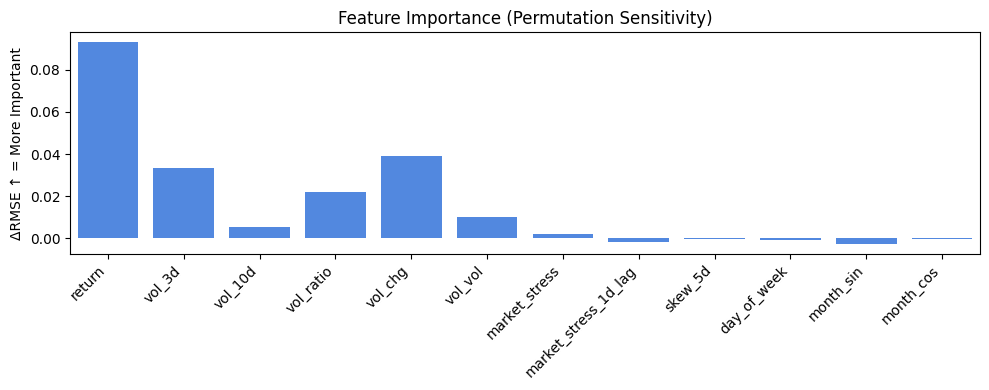

In [8]:
# ============================================================
# 🔍 Feature Importance via Permutation Sensitivity
# ============================================================
from copy import deepcopy


DEVICE = cfg.device
MODEL = model.to(DEVICE)
MODEL.eval()

# Take a small validation batch
t_id, X, y = next(iter(val_loader))
t_id, X, y = t_id.to(DEVICE), X.to(DEVICE), y.to(DEVICE)

# Base predictions
with torch.no_grad():
    base_pred = MODEL(t_id, X).cpu().numpy()
base_rmse = np.sqrt(mean_squared_error(y.cpu().numpy().flatten(), base_pred.flatten()))

feature_names = ["return"] + (cfg.extra_features or [])
delta_rmse = []

for i, feat in enumerate(feature_names):
    X_perm = deepcopy(X)
    idx = torch.randperm(X.shape[0])
    X_perm[:, :, i] = X_perm[idx, :, i]  # shuffle along batch dimension
    with torch.no_grad():
        pred_perm = MODEL(t_id, X_perm).cpu().numpy()
    rmse_perm = np.sqrt(mean_squared_error(y.cpu().numpy().flatten(), pred_perm.flatten()))
    delta_rmse.append(rmse_perm - base_rmse)

# --- Plot ---
plt.figure(figsize=(10,4))
sns.barplot(x=feature_names, y=delta_rmse, color="#3B82F6")
plt.xticks(rotation=45, ha="right")
plt.ylabel("ΔRMSE ↑ = More Important")
plt.title("Feature Importance (Permutation Sensitivity)")
plt.tight_layout()
plt.show()


In [9]:
# ============================================================
# 🏅 Best / Worst Performing Tickers
# ============================================================

best_tickers = (
    metrics_df.groupby("ticker")["rmse"].mean()
    .sort_values()
    .head(10)
    .reset_index()
)
worst_tickers = (
    metrics_df.groupby("ticker")["rmse"].mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

print("✅ Easiest (Best-Fit) Tickers:")
display(best_tickers)

print("⚠️ Hardest (High-Vol / Poor-Fit) Tickers:")
display(worst_tickers)


✅ Easiest (Best-Fit) Tickers:


,ticker,rmse
0,HYG,0.015629
1,TLT,0.015867
2,KO,0.023213
3,SO,0.024802
4,DUK,0.025455
5,AEP,0.025470
6,GLD,0.026411
7,PG,0.028459
8,HD,0.030061
9,KMB,0.030814


⚠️ Hardest (High-Vol / Poor-Fit) Tickers:


,ticker,rmse
0,ORCL,0.219558
1,PARA,0.205588
2,WBD,0.186020
3,VXX,0.178229
4,AMC,0.165171
5,UNH,0.156227
6,INTC,0.150891
7,COIN,0.141086
8,GME,0.139404
9,FCX,0.118006


In [2]:
# ===============================
# 🧪 Features for Multi-Horizon v2
# ===============================
multi_df = pd.read_csv("../data/processed/global_volatility_dataset.csv")

EPS = 1e-6
df = multi_df.copy()

# Ensure types / order
if not np.issubdtype(df["date"].dtype, np.datetime64):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values(["ticker", "date"])

# Base target (you already used this)
df["realized_vol_log"] = np.log(df["realized_vol"] + EPS)

g = df.groupby("ticker", group_keys=False)

# Volatility structure
df["vol_3d"]   = g["realized_vol"].apply(lambda s: s.rolling(3,  min_periods=1).mean())
df["vol_10d"]  = g["realized_vol"].apply(lambda s: s.rolling(10, min_periods=1).mean())
df["vol_ratio"]= df["vol_3d"] / (df["vol_10d"] + EPS)
df["vol_chg"]  = df["vol_3d"] - df["vol_10d"]
df["vol_vol"]  = g["realized_vol"].apply(lambda s: s.rolling(10, min_periods=2).std())

# “Target smoothing” (you said you already used it; keep it)
df["target_smooth"] = g["realized_vol_log"].apply(lambda s: s.ewm(alpha=0.3, adjust=False).mean())

# Market cross-section dispersion (kept)
df["market_stress"] = df.groupby("date")["return"].transform(lambda x: x.std())
df["market_stress_1d_lag"] = g["market_stress"].shift(1)

# Skew (kept)
def _rolling_skew(x):
    if len(x) < 3: return np.nan
    m, sd = np.mean(x), np.std(x) if np.std(x) > 0 else EPS
    return np.mean(((x - m) / sd) ** 3)
df["skew_5d"] = g["return"].apply(lambda s: s.rolling(5, min_periods=3).apply(_rolling_skew, raw=True))

# Calendar features (cheap)
df["day_of_week"] = df["date"].dt.dayofweek / 6.0
df["month_sin"]   = np.sin(2 * np.pi * df["date"].dt.month / 12)
df["month_cos"]   = np.cos(2 * np.pi * df["date"].dt.month / 12)

# **New** instantaneous volatility proxies (no new data)
df["abs_return"]  = df["return"].abs()
df["ret_sq"]      = df["return"] ** 2

# Fill per-ticker to remove gaps from rolling windows
df = df.groupby("ticker", group_keys=False).apply(lambda g: g.ffill().bfill())

multi_df = df  # keep original name for the training call

C:\Users\rahul\AppData\Local\Temp\ipykernel_27120\2062581290.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("ticker", group_keys=False).apply(lambda g: g.ffill().bfill())


In [4]:
# ===============================
# 🚀 Train Multi-Horizon v2 (no loops)
# ===============================
HORIZONS = [1, 5, 10]
EXTRA_FEATURES = [
    "vol_3d","vol_10d","vol_ratio","vol_chg","vol_vol",
    "market_stress","market_stress_1d_lag","skew_5d",
    "day_of_week","month_sin","month_cos",
    "target_smooth","abs_return","ret_sq"
]

cfg = TrainConfig(
    window=40,
    horizons=HORIZONS,
    stride=1,
    val_start="2025-01-01",
    target_col="realized_vol_log",
    extra_features=EXTRA_FEATURES,
    # training
    epochs=20,                 # keep time in check; cosine anneal helps
    lr=3e-4,
    batch_size=256,
    cosine_schedule=True,
    oversample_high_vol=False, # (optional) keep off for stability in MH
    device="cpu",
    # regularization / architecture
    dropout=0.3,
    use_layernorm=True,
    separate_heads=True,
    loss_horizon_weights=[0.5, 0.3, 0.2],  # prioritize 1d
    dynamic_window_jitter=5,   # randomize window length ∈ [35,45] for train
    grad_clip=1.0,
    # dataloader perf
    num_workers=0,             # bump if you have cores
    pin_memory=False
)


model, hist, val_loader, ticker_to_id, scalers, features = train_global_model(multi_df, cfg)

print(f"\n✅ Trained on {len(ticker_to_id)} tickers | Horizons={HORIZONS}")
print(f"📉 Final Train: {hist['train'][-1]:.4f} | Val: {hist['val'][-1]:.4f}")



🚀 Training GlobalVolForecaster on 104 tickers...

Epoch 1/20 | Train Loss: 0.0270 | Val Loss: 0.0208
Epoch 2/20 | Train Loss: 0.0176 | Val Loss: 0.0185
Epoch 3/20 | Train Loss: 0.0165 | Val Loss: 0.0185
Epoch 4/20 | Train Loss: 0.0159 | Val Loss: 0.0181
Epoch 5/20 | Train Loss: 0.0154 | Val Loss: 0.0189
Epoch 6/20 | Train Loss: 0.0150 | Val Loss: 0.0186
Epoch 7/20 | Train Loss: 0.0145 | Val Loss: 0.0187
Epoch 8/20 | Train Loss: 0.0141 | Val Loss: 0.0189
Epoch 9/20 | Train Loss: 0.0137 | Val Loss: 0.0191
Epoch 10/20 | Train Loss: 0.0133 | Val Loss: 0.0198
Epoch 11/20 | Train Loss: 0.0129 | Val Loss: 0.0202
Epoch 12/20 | Train Loss: 0.0125 | Val Loss: 0.0205
Epoch 13/20 | Train Loss: 0.0121 | Val Loss: 0.0213
Epoch 14/20 | Train Loss: 0.0119 | Val Loss: 0.0213
Epoch 15/20 | Train Loss: 0.0116 | Val Loss: 0.0215
Epoch 16/20 | Train Loss: 0.0113 | Val Loss: 0.0223
Epoch 17/20 | Train Loss: 0.0112 | Val Loss: 0.0222
Epoch 18/20 | Train Loss: 0.0110 | Val Loss: 0.0222
Epoch 19/20 | Train Lo

In [5]:
# --- 4) Save checkpoint + metadata + pickle --------------------------
import pickle

os.makedirs("checkpoints", exist_ok=True)

base = "checkpoints/global_vol_forecaster_multi_v2"
ckpt_path = f"{base}.pth"
meta_path = f"{base}.meta.json"
full_pkl_path = f"{base}_full.pkl"
bundle_pkl_path = f"{base}_bundle.pkl"

# 1) Weights checkpoint
torch.save(model.state_dict(), ckpt_path)

# 2) Metadata JSON
config_dict = {
    "window": cfg.window,
    "stride": cfg.stride,
    "val_start": cfg.val_start,
    "batch_size": cfg.batch_size,
    "lr": cfg.lr,
    "epochs": cfg.epochs,
    "device": cfg.device,
    "cosine_schedule": cfg.cosine_schedule,
    "oversample_high_vol": cfg.oversample_high_vol,
    "target_col": cfg.target_col,
}
with open(meta_path, "w") as f:
    json.dump({
        "ticker_to_id": ticker_to_id,
        "features": features,
        "horizons": HORIZONS,
        "config": config_dict,
    }, f, indent=2)

# 3) Full model pickle (architecture + weights; requires same module path on load)
with open(full_pkl_path, "wb") as f:
    pickle.dump(model, f)

# 4) Portable bundle pickle (state_dict + metadata; more robust to refactors)
bundle = {
    "arch": model.__class__.__name__,
    "module_path": model.__class__.__module__,
    "state_dict": {k: v.cpu() for k, v in model.state_dict().items()},
    "ticker_to_id": ticker_to_id,
    "features": features,
    "horizons": HORIZONS,
    "scalers": scalers,
    "config": config_dict,
}
with open(bundle_pkl_path, "wb") as f:
    pickle.dump(bundle, f)

print(f"💾 Saved checkpoint -> {ckpt_path}")
print(f"💾 Saved metadata   -> {meta_path}")
print(f"💾 Saved full pkl   -> {full_pkl_path}")
print(f"💾 Saved bundle pkl -> {bundle_pkl_path}")

💾 Saved checkpoint -> checkpoints/global_vol_forecaster_multi_v2.pth
💾 Saved metadata   -> checkpoints/global_vol_forecaster_multi_v2.meta.json
💾 Saved full pkl   -> checkpoints/global_vol_forecaster_multi_v2_full.pkl
💾 Saved bundle pkl -> checkpoints/global_vol_forecaster_multi_v2_bundle.pkl


,horizon,rmse,mae
0,1,0.069852,0.036435
1,5,0.114148,0.062509
2,10,0.162391,0.094275


,ticker,horizon,rmse,mae
0,AAPL,1,0.081265,0.047192
1,AAPL,5,0.130533,0.074338
2,AAPL,10,0.197041,0.099911
3,ABBV,1,0.031998,0.020717
4,ABBV,5,0.058237,0.039160


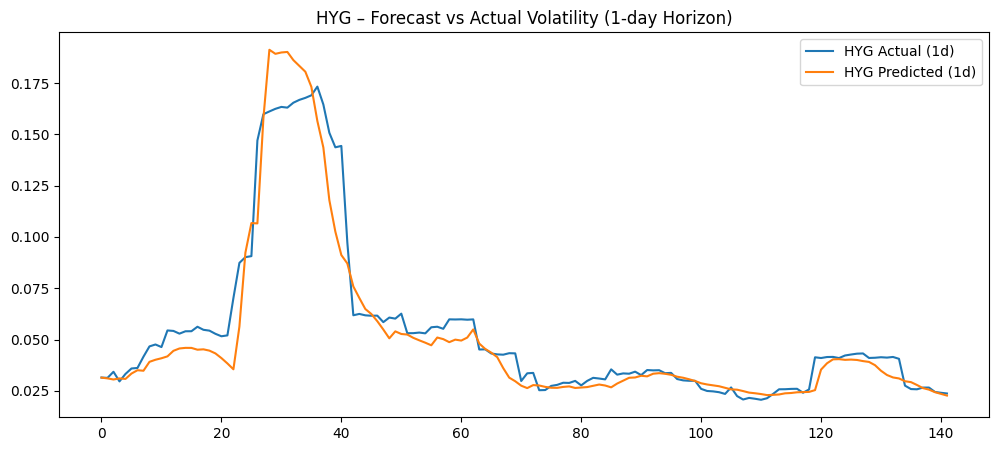

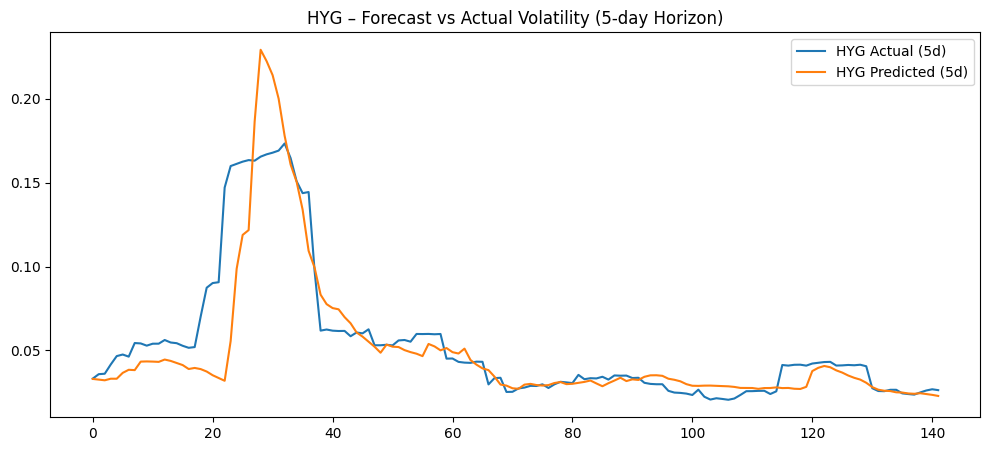

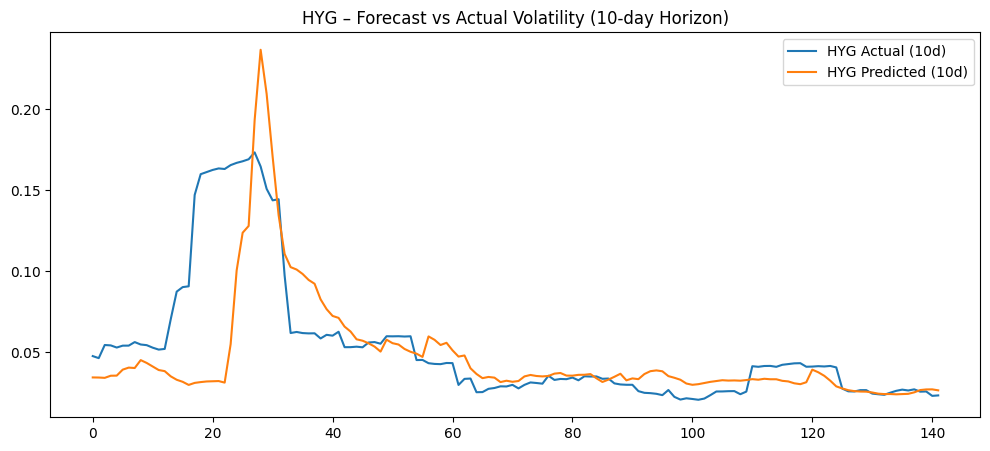

💾 Saved metrics -> global_lstm_multi_metrics_v2.csv


In [7]:
# ============================================================
# 📈 Evaluate Multi-Horizon GlobalVolForecaster (1d, 5d, 10d)
# ============================================================


DEVICE = cfg.device
MODEL = model.to(DEVICE)
MODEL.eval()

# --- Run inference ---
all_preds, all_trues, all_tids = [], [], []

with torch.no_grad():
    for tid, X, y in val_loader:
        tid, X, y = tid.to(DEVICE), X.to(DEVICE), y.to(DEVICE)
        preds = MODEL(tid, X)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(y.cpu().numpy())
        all_tids.append(tid.cpu().numpy())

preds_scaled = np.concatenate(all_preds)
trues_scaled = np.concatenate(all_trues)
tids = np.concatenate(all_tids)

# --- Directly exp-transform since target was log(vol) ---
preds_vol = np.exp(preds_scaled)
trues_vol = np.exp(trues_scaled)

# --- Aggregate metrics per horizon ---
horizons = cfg.horizons if isinstance(cfg.horizons, (list, tuple)) else [cfg.horizons]
rows = []
for h_idx, h in enumerate(horizons):
    rmse = np.sqrt(mean_squared_error(trues_vol[:, h_idx], preds_vol[:, h_idx]))
    mae = mean_absolute_error(trues_vol[:, h_idx], preds_vol[:, h_idx])
    rows.append({"horizon": h, "rmse": rmse, "mae": mae})
metrics_overall = pd.DataFrame(rows)
display(metrics_overall.style.set_caption("📊 Multi-Horizon RMSE & MAE"))

# --- Per-ticker metrics ---
rows = []
id_to_ticker = {v: k for k, v in ticker_to_id.items()}
for tid in np.unique(tids):
    tkr = id_to_ticker[int(tid)]
    mask = (tids == tid)
    for h_idx, h in enumerate(horizons):
        rows.append({
            "ticker": tkr,
            "horizon": h,
            "rmse": np.sqrt(mean_squared_error(trues_vol[mask, h_idx], preds_vol[mask, h_idx])),
            "mae": mean_absolute_error(trues_vol[mask, h_idx], preds_vol[mask, h_idx])
        })
metrics_df = pd.DataFrame(rows)
display(metrics_df.head())

# --- Representative plots for best tickers in each horizon ---
for target_h in [1, 5, 10]:
    if target_h not in horizons:
        continue
    best_tkr = (
        metrics_df.query(f"horizon == {target_h}")
        .sort_values("rmse")
        .iloc[0]["ticker"]
    )
    tid_best = list(id_to_ticker.keys())[list(id_to_ticker.values()).index(best_tkr)]
    mask = (tids == tid_best)
    h_idx = horizons.index(target_h)
    
    plt.figure(figsize=(12,5))
    plt.plot(trues_vol[mask][:200, h_idx], label=f"{best_tkr} Actual ({target_h}d)")
    plt.plot(preds_vol[mask][:200, h_idx], label=f"{best_tkr} Predicted ({target_h}d)")
    plt.title(f"{best_tkr} – Forecast vs Actual Volatility ({target_h}-day Horizon)")
    plt.legend()
    plt.show()

# --- Save metrics ---
metrics_df.to_csv("../data/metrics/global_lstm_multi_metrics_v2.csv", index=False)
print("💾 Saved metrics -> global_lstm_multi_metrics_v2.csv")

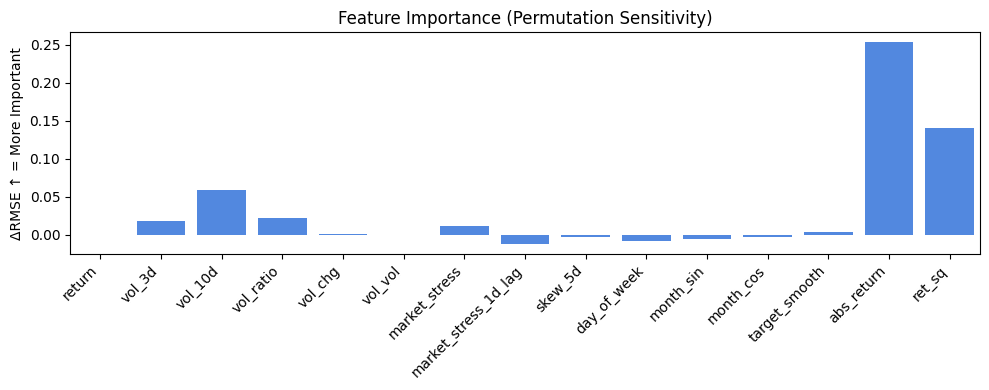

In [8]:
# ============================================================
# 🔍 Feature Importance via Permutation Sensitivity
# ============================================================
from copy import deepcopy


DEVICE = cfg.device
MODEL = model.to(DEVICE)
MODEL.eval()

# Take a small validation batch
t_id, X, y = next(iter(val_loader))
t_id, X, y = t_id.to(DEVICE), X.to(DEVICE), y.to(DEVICE)

# Base predictions
with torch.no_grad():
    base_pred = MODEL(t_id, X).cpu().numpy()
base_rmse = np.sqrt(mean_squared_error(y.cpu().numpy().flatten(), base_pred.flatten()))

feature_names = ["return"] + (cfg.extra_features or [])
delta_rmse = []

for i, feat in enumerate(feature_names):
    X_perm = deepcopy(X)
    idx = torch.randperm(X.shape[0])
    X_perm[:, :, i] = X_perm[idx, :, i]  # shuffle along batch dimension
    with torch.no_grad():
        pred_perm = MODEL(t_id, X_perm).cpu().numpy()
    rmse_perm = np.sqrt(mean_squared_error(y.cpu().numpy().flatten(), pred_perm.flatten()))
    delta_rmse.append(rmse_perm - base_rmse)

# --- Plot ---
plt.figure(figsize=(10,4))
sns.barplot(x=feature_names, y=delta_rmse, color="#3B82F6")
plt.xticks(rotation=45, ha="right")
plt.ylabel("ΔRMSE ↑ = More Important")
plt.title("Feature Importance (Permutation Sensitivity)")
plt.tight_layout()
plt.show()


In [9]:
# ============================================================
# 🏅 Best / Worst Performing Tickers
# ============================================================

best_tickers = (
    metrics_df.groupby("ticker")["rmse"].mean()
    .sort_values()
    .head(10)
    .reset_index()
)
worst_tickers = (
    metrics_df.groupby("ticker")["rmse"].mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

print("✅ Easiest (Best-Fit) Tickers:")
display(best_tickers)

print("⚠️ Hardest (High-Vol / Poor-Fit) Tickers:")
display(worst_tickers)

✅ Easiest (Best-Fit) Tickers:


,ticker,rmse
0,HYG,0.021671
1,KO,0.030240
2,AEP,0.031510
3,TLT,0.031665
4,GLD,0.037736
5,KMB,0.039799
6,SO,0.040262
7,DUK,0.040568
8,PG,0.041537
9,GIS,0.041934


⚠️ Hardest (High-Vol / Poor-Fit) Tickers:


,ticker,rmse
0,AMC,0.328157
1,ORCL,0.319503
2,PARA,0.304120
3,WBD,0.255200
4,VXX,0.239727
5,UNH,0.228906
6,INTC,0.212880
7,AMD,0.193398
8,COIN,0.185867
9,GME,0.172202


In [ ]:
# ===============================
# 🚀 Train GlobalVolForecaster v3
# ===============================
from volsense_pkg.models.global_vol_forecaster import TrainConfig, train_global_model

HORIZONS = [1, 5, 10]

# Keep your final v2 set, but feel free to prune 'target_smooth' OR 'ret_sq'
EXTRA_FEATURES = [
    "vol_3d","vol_10d","vol_ratio","vol_chg","vol_vol",
    "market_stress","market_stress_1d_lag","skew_5d",
    "day_of_week","month_sin","month_cos",
    "abs_return","ret_sq"  # <- keep one of these next run if you want to prune
]

cfg = TrainConfig(
    window=40,
    horizons=HORIZONS,
    stride=2,                         # decorrelate + speed
    val_start="2025-01-01",
    target_col="realized_vol_log",
    extra_features=EXTRA_FEATURES,
    # training
    epochs=30,
    lr=3e-4,
    batch_size=256,
    device="cpu",
    # arch/regularization
    dropout=0.3,
    use_layernorm=True,
    separate_heads=True,
    attention=True,
    residual_head=True,
    feat_dropout_p=0.10,
    variational_dropout_p=0.10,
    loss_horizon_weights=[0.6, 0.25, 0.15],
    # sched/ema/earlystop
    cosine_schedule=True,
    cosine_restarts=True,
    use_ema=True,
    ema_decay=0.995,
    early_stop=True,
    patience=4,
    grad_clip=1.0,
    # dataloader
    num_workers=0,
    pin_memory=False,
)

model, hist, val_loader, ticker_to_id, scalers, features = train_global_model(multi_df, cfg)

print(f"\n✅ Trained on {len(ticker_to_id)} tickers | Horizons={HORIZONS}")
print(f"📉 Final Train: {hist['train'][-1]:.4f} | Val: {hist['val'][-1]:.4f}")


🚀 Training GlobalVolForecaster on 104 tickers...

Epoch 1/30 | Train Loss: 0.0308 | Val Loss: 0.0204
Epoch 2/30 | Train Loss: 0.0171 | Val Loss: 0.0164
Epoch 3/30 | Train Loss: 0.0146 | Val Loss: 0.0153
Epoch 4/30 | Train Loss: 0.0129 | Val Loss: 0.0144
Epoch 5/30 | Train Loss: 0.0119 | Val Loss: 0.0140
Epoch 6/30 | Train Loss: 0.0113 | Val Loss: 0.0136
Epoch 7/30 | Train Loss: 0.0109 | Val Loss: 0.0138
Epoch 8/30 | Train Loss: 0.0107 | Val Loss: 0.0138
Epoch 9/30 | Train Loss: 0.0113 | Val Loss: 0.0136
